In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import catboost as cb
import shap
import plotly.express as px
import pickle

In [3]:
# Load datasets
train_df = pd.read_csv("C:/Users/ASUS/Downloads/regression-tabular-california-housing/train.csv")
test_df = pd.read_csv("C:/Users/ASUS/Downloads/regression-tabular-california-housing/test.csv")


In [6]:
train_df.head(), train_df.columns

(   id  MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
 0   0  2.3859      15.0  3.827160   1.112100      1280.0  2.486989     34.60   
 1   1  3.7188      17.0  6.013373   1.054217      1504.0  3.813084     38.69   
 2   2  4.7750      27.0  6.535604   1.103175      1061.0  2.464602     34.71   
 3   3  2.4138      16.0  3.350203   0.965432      1255.0  2.089286     32.66   
 4   4  3.7500      52.0  4.284404   1.069246      1793.0  1.604790     37.80   
 
    Longitude  MedHouseVal  
 0    -120.12        0.980  
 1    -121.22        0.946  
 2    -120.45        1.576  
 3    -117.09        1.336  
 4    -122.41        4.500  ,
 Index(['id', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
        'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal'],
       dtype='object'))

In [8]:
# Remove duplicate rows
train_df = train_df.drop_duplicates()

In [10]:
# Handle missing values (if any)
train_df = train_df.dropna()


In [12]:
# Remove outliers using IQR
Q1 = train_df.quantile(0.25)
Q3 = train_df.quantile(0.75)
IQR = Q3 - Q1
train_df = train_df[~((train_df < (Q1 - 1.5 * IQR)) | (train_df > (Q3 + 1.5 * IQR))).any(axis=1)]

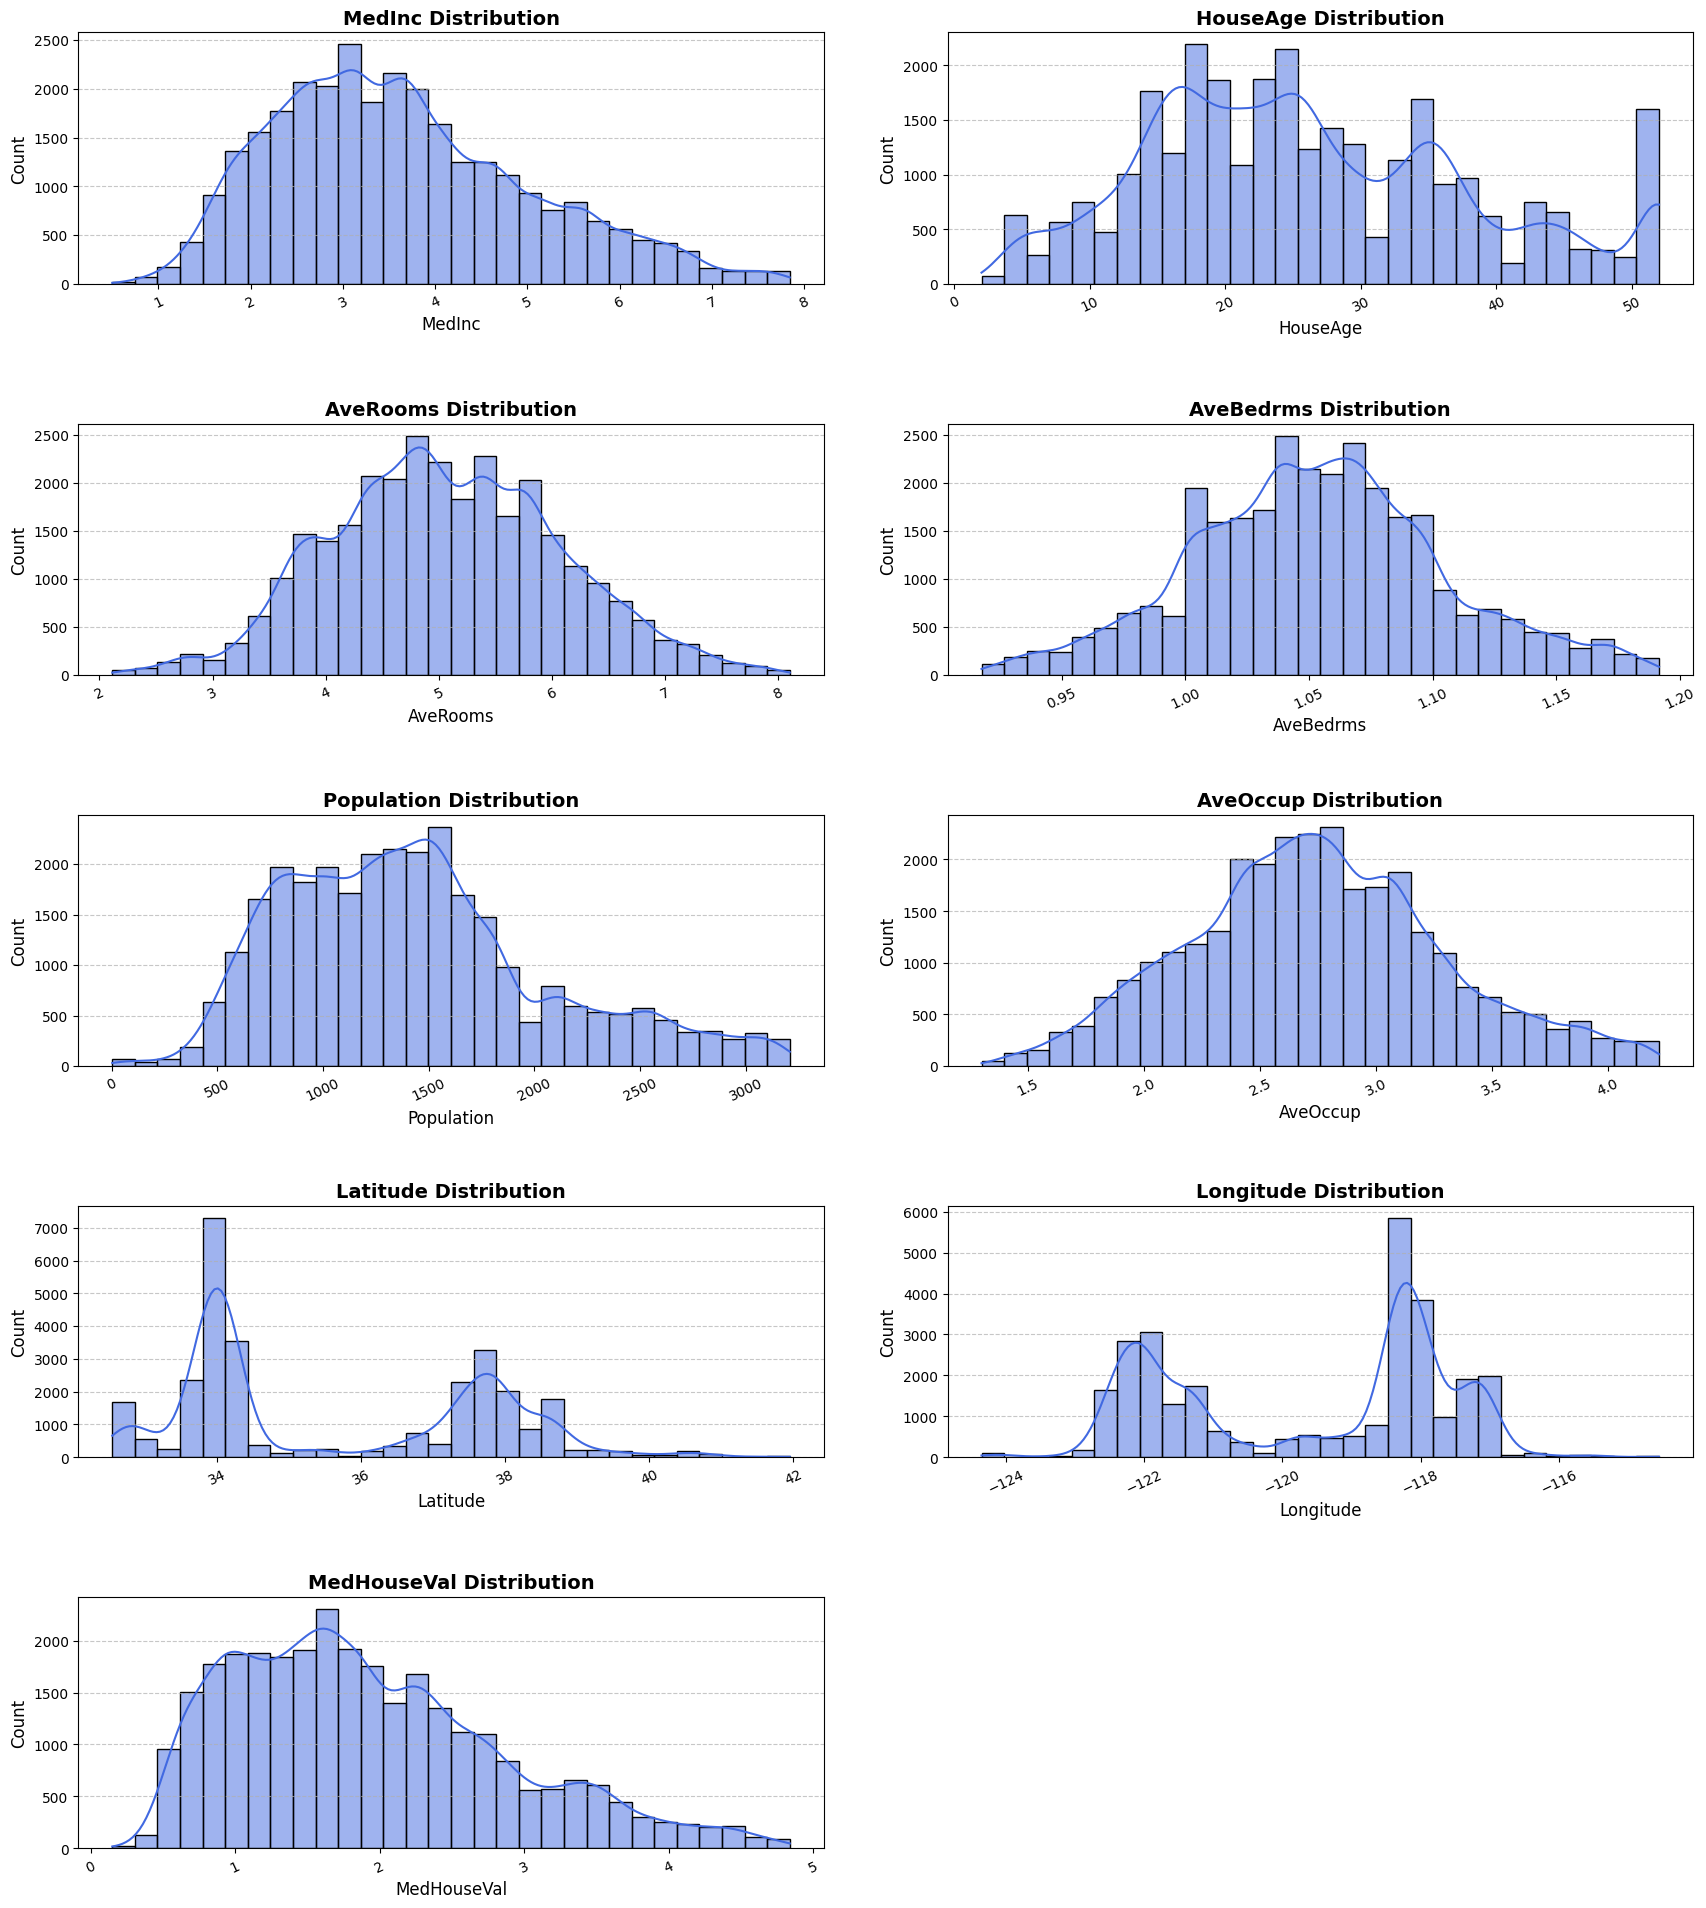

In [14]:
# Identify numerical columns (excluding 'id' column)
numerical_cols = train_df.select_dtypes(include=['number']).columns
numerical_cols = [col for col in numerical_cols if col.lower() != 'id']  # Exclude 'id' column

# Define figure size
plt.figure(figsize=(18, 20))

# Define grid layout
num_cols = 2  # Two columns per row
num_rows = (len(numerical_cols) // num_cols) + 1  # Dynamic row calculation

# Loop through numerical columns and create histograms
for i, col in enumerate(numerical_cols):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(train_df[col], bins=30, kde=True, edgecolor='black', color='royalblue')
    plt.title(f"{col} Distribution", fontsize=14, fontweight='bold')
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=25)  # Improve label readability
    plt.grid(axis='y', linestyle='--', alpha=0.7)  # Enhance grid visibility

# Adjust layout for better spacing
plt.tight_layout(pad=4)
plt.show()

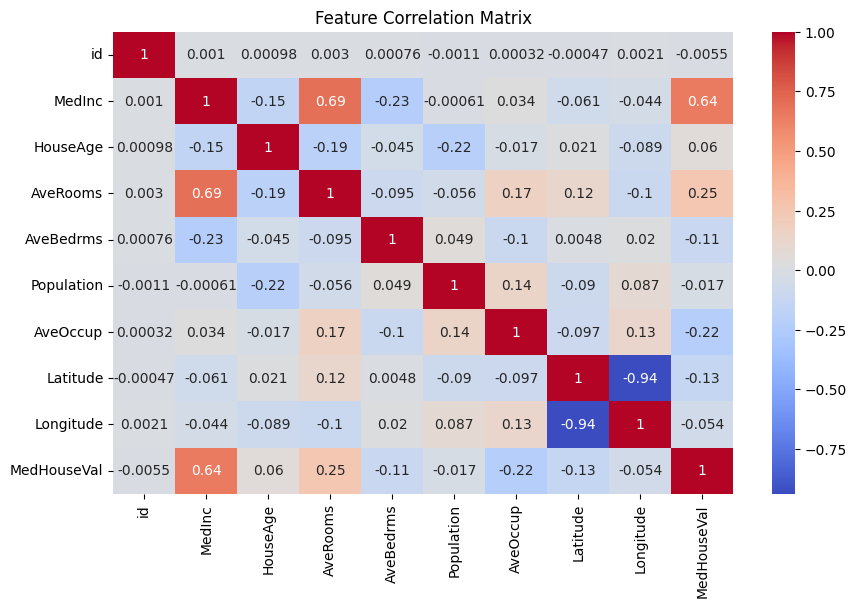

In [16]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()

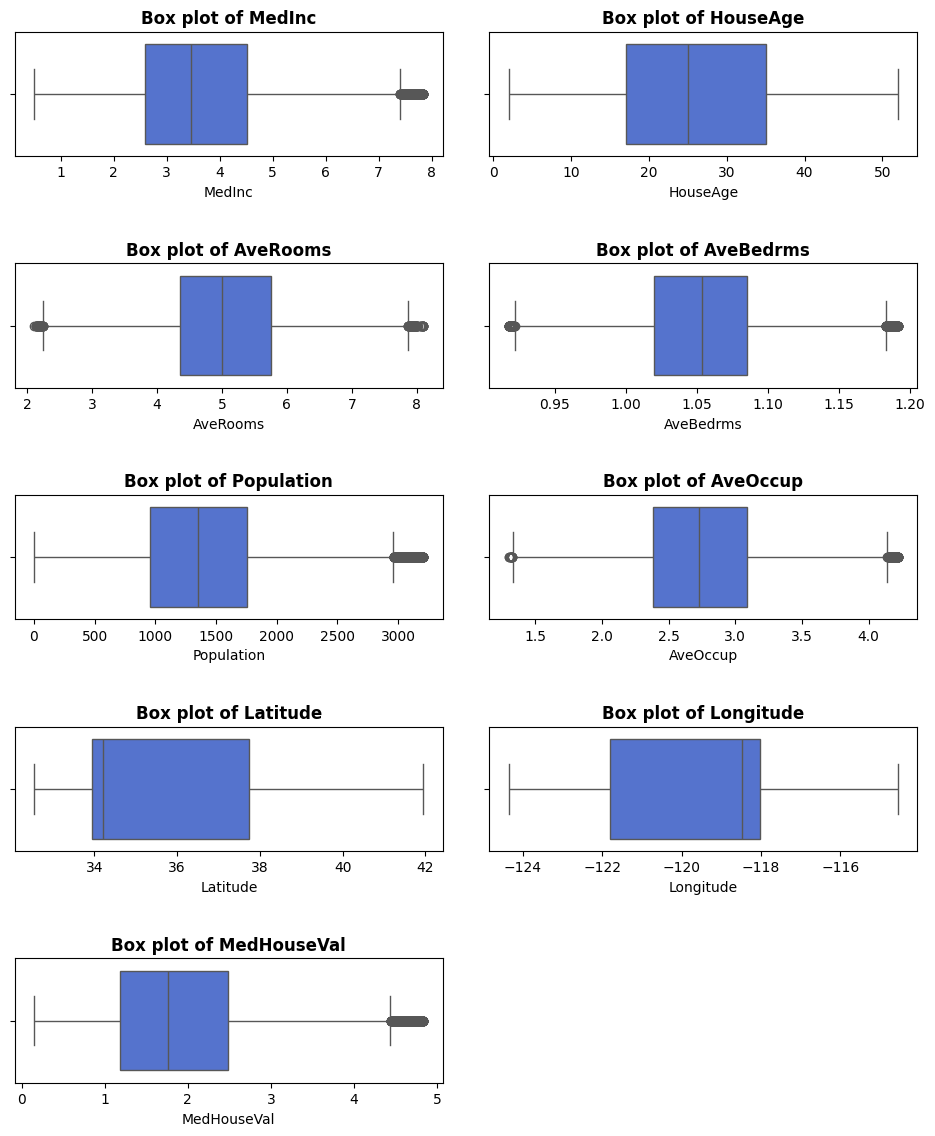

In [36]:
# Identify numerical columns (excluding 'id' column)
numerical_cols = train_df.select_dtypes(include=['number']).columns
numerical_cols = [col for col in numerical_cols if col.lower() != 'id']  # Exclude 'id' column

# Define the number of rows and columns dynamically
num_cols = 2  # Two columns per row
num_rows = -(-len(numerical_cols) // num_cols)  # Ceiling division to avoid empty plots

# Create subplots
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 12))
axes = axes.flatten()  # Flatten axes for easy iteration

# Loop through numerical columns and create boxplots
for i, column in enumerate(numerical_cols):
    sns.boxplot(x=train_df[column], ax=axes[i], color="royalblue")
    axes[i].set_title(f'Box plot of {column}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(column, fontsize=10)

# Hide any unused subplots (if columns are odd-numbered)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])  # Remove extra blank graphs

# Adjust layout for better spacing
plt.tight_layout(pad=3)
plt.show()

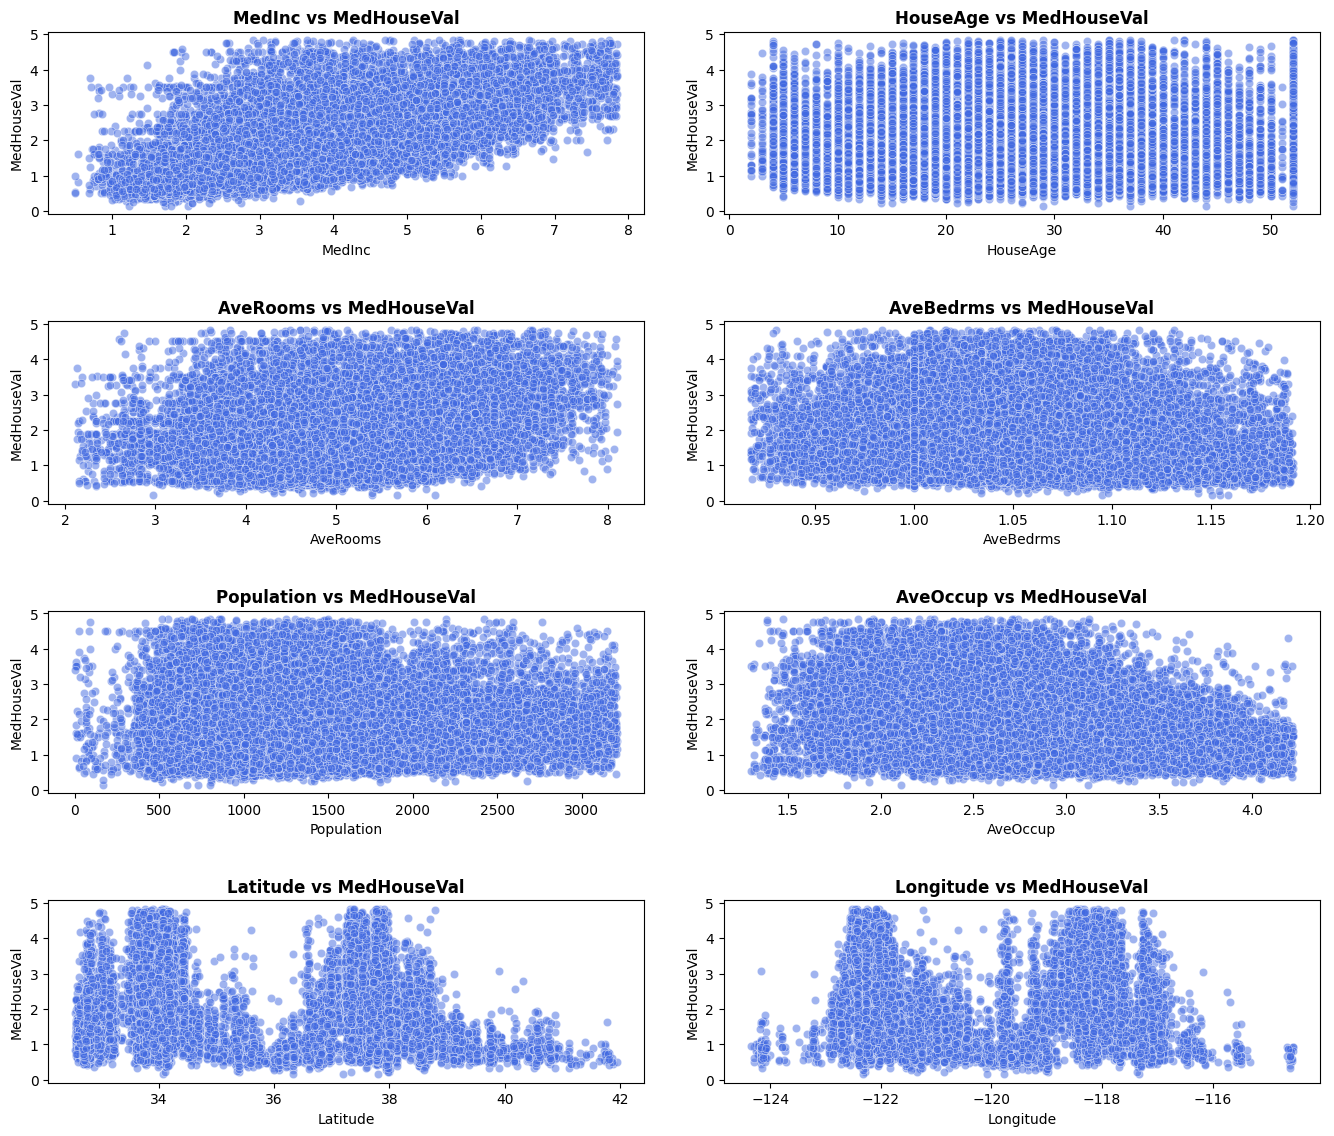

In [20]:
# Define input features (X) and target variable (Y)
X = ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']
Y = 'MedHouseVal'

# Define subplots (4 rows, 2 columns)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(14, 12))  # Adjust figure size for better visibility
axes = axes.flatten()  # Flatten axes for iteration

# Loop through each feature and create scatter plots
for i, feature in enumerate(X):
    sns.scatterplot(x=train_df[feature], y=train_df[Y], ax=axes[i], color='royalblue', alpha=0.5)
    axes[i].set_title(f"{feature} vs {Y}", fontsize=12, fontweight='bold')
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel(Y, fontsize=10)

# Adjust layout for better spacing
plt.tight_layout(pad=3)
plt.show()

In [22]:
# Drop 'id' column as it's not useful for training
train_df = train_df.drop(columns=["id"])
test_ids = test_df["id"]  # Save test IDs for submission
X_test = test_df.drop(columns=["id"])


In [24]:
# Split features and target variable
X = train_df.drop(columns=["MedHouseVal"])
y = train_df["MedHouseVal"]


In [26]:
# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [30]:
# LightGBM Hyperparameter Tuning
lgb_params = {'n_estimators': [300, 500], 'learning_rate': [0.01, 0.05], 'max_depth': [5, 7]}
lgb_grid = GridSearchCV(lgb.LGBMRegressor(random_state=42), lgb_params, cv=3, scoring='neg_root_mean_squared_error')
lgb_grid.fit(X_train_scaled, y_train)
lgb_model = lgb_grid.best_estimator_
print(f"Best LightGBM Params: {lgb_grid.best_params_}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000303 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 15802, number of used features: 8
[LightGBM] [Info] Start training from score 1.918489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

In [31]:
# XGBoost Hyperparameter Tuning
xgb_params = {'n_estimators': [300, 500], 'learning_rate': [0.01, 0.05], 'max_depth': [5, 7]}
xgb_grid = GridSearchCV(xgb.XGBRegressor(random_state=42), xgb_params, cv=3, scoring='neg_root_mean_squared_error')
xgb_grid.fit(X_train_scaled, y_train)
xgb_model = xgb_grid.best_estimator_
print(f"Best XGBoost Params: {xgb_grid.best_params_}")

Best XGBoost Params: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500}


In [33]:
# CatBoost Model
cat_model = cb.CatBoostRegressor(n_estimators=500, learning_rate=0.05, depth=6, random_state=42, verbose=0)
cat_model.fit(X_train_scaled, y_train)

In [34]:
# Neural Network Model
nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', solver='adam', max_iter=500, random_state=42)
nn_model.fit(X_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=500, random_state=42)

In [38]:
# Stacking Model
stacking_model = StackingRegressor(
    estimators=[('lgb', lgb_model), ('xgb', xgb_model), ('cat', cat_model), ('nn', nn_model)],
    final_estimator=LinearRegression()
)
stacking_model.fit(X_train_scaled, y_train)
stacking_val_pred = stacking_model.predict(X_val_scaled)
stacking_rmse = np.sqrt(mean_squared_error(y_val, stacking_val_pred))
print(f"Stacking Model RMSE: {stacking_rmse}")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 23704, number of used features: 8
[LightGBM] [Info] Start training from score 1.916886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [I

In [40]:
# LightGBM Model
lgb_model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
lgb_model.fit(X_train_scaled, y_train)
lgb_val_pred = lgb_model.predict(X_val_scaled)
lgb_rmse = np.sqrt(mean_squared_error(y_val, lgb_val_pred))
print(f"LightGBM RMSE: {lgb_rmse}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 23704, number of used features: 8
[LightGBM] [Info] Start training from score 1.916886
LightGBM RMSE: 0.5075038368655019


In [41]:
# XGBoost Model
xgb_model = xgb.XGBRegressor(n_estimators=200, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train_scaled, y_train)
xgb_val_pred = xgb_model.predict(X_val_scaled)
xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_val_pred))
print(f"XGBoost RMSE: {xgb_rmse}")


XGBoost RMSE: 0.5103502288144492


In [45]:
# CatBoost Model
cat_model = cb.CatBoostRegressor(n_estimators=200, learning_rate=0.05, depth=6, random_state=42, verbose=0)
cat_model.fit(X_train_scaled, y_train)
cat_val_pred = cat_model.predict(X_val_scaled)
cat_rmse = np.sqrt(mean_squared_error(y_val, cat_val_pred))
print(f"CatBoost RMSE: {cat_rmse}")

CatBoost RMSE: 0.5218917050999604


In [47]:
# Ensemble Model (LightGBM + XGBoost)
voting_model = VotingRegressor(estimators=[('lgb', lgb_model), ('xgb', xgb_model)])
voting_model.fit(X_train_scaled, y_train)
voting_val_pred = voting_model.predict(X_val_scaled)
voting_rmse = np.sqrt(mean_squared_error(y_val, voting_val_pred))
print(f"Ensemble Model RMSE: {voting_rmse}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 23704, number of used features: 8
[LightGBM] [Info] Start training from score 1.916886
Ensemble Model RMSE: 0.506879744684262


In [49]:
# Stacking Regressor (Advanced Ensemble Model)
stacking_model = StackingRegressor(
    estimators=[('lgb', lgb_model), ('xgb', xgb_model), ('cat', cat_model)],
    final_estimator=LinearRegression()
)
stacking_model.fit(X_train_scaled, y_train)
stacking_val_pred = stacking_model.predict(X_val_scaled)
stacking_rmse = np.sqrt(mean_squared_error(y_val, stacking_val_pred))
print(f"Stacking Model RMSE: {stacking_rmse}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 23704, number of used features: 8
[LightGBM] [Info] Start training from score 1.916886
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 18963, number of used features: 8
[LightGBM] [Info] Start training from score 1.915757
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1837
[LightGBM] [Info] Number of data points in the train set: 

In [56]:
# Final Prediction on Test Set
y_test_pred = stacking_model.predict(X_test_scaled)


In [50]:
# Input Actual Data
input_data = {
    'MedInc': float(input("Enter Median Income: ")),
    'HouseAge': float(input("Enter House Age: ")),
    'AveRooms': float(input("Enter Average Rooms: ")),
    'AveBedrms': float(input("Enter Average Bedrooms: ")),
    'Population': float(input("Enter Population: ")),
    'AveOccup': float(input("Enter Average Occupancy: ")),
    'Latitude': float(input("Enter Latitude: ")),
    'Longitude': float(input("Enter Longitude: "))
}



Enter Median Income:  3
Enter House Age:  17
Enter Average Rooms:  3
Enter Average Bedrooms:  4
Enter Population:  3
Enter Average Occupancy:  2.6
Enter Latitude:  6
Enter Longitude:  9


In [53]:
# Convert Input to DataFrame
input_df = pd.DataFrame([input_data])


In [55]:
# Scale Input Data
input_scaled = scaler.transform(input_df)

In [57]:
# Predict Price
predicted_price = stacking_model.predict(input_scaled)


In [59]:
print(f"Predicted House Price: {predicted_price[0]:.2f}")

Predicted House Price: 1.19


In [57]:
# Save the trained Stacking Model
with open("Housing_Price.pkl", "wb") as file:
    pickle.dump(stacking_model, file)
print("Model saved as 'Housing_Price.pkl'")


Model saved as 'Housing_Price.pkl'
